# Imports & Paths

In [4]:
import os
import sys
from sklearn.ensemble import *

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
    sys.path.append(PATH_func)
elif os.name == 'posix':
    PATH = '/home/msnow/git/data_science/'
    DATA = '/data/msnow/data_science/'
    sys.path.append(PATH+'src/')

In [6]:
%matplotlib inline

from features.imports import *
from features.utilities import *
from features.fastai import *

/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load in data

In [8]:
df_raw = pd.read_feather(f'{DATA}/bbfb/bulldozer')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [9]:
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_train_val(df_trn, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)
raw_train, raw_valid = split_train_val(df_raw, n_trn)

In [10]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

# Basic data structures

In [11]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [22]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf

In [24]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [25]:
m.trees[0]

In [17]:
m.create_tree()

In [23]:
m.create_tree().rnd_idxs

In [26]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [27]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [28]:
m.trees[0]

n: 1000; val:10.079014121552744

In [29]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Single branch

### Find best split given variable

If we're going to compare our RF to the scikit-learn implementation we need to know exactl which rows it is using

In [30]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [31]:
tree

n: 1000; val:10.079014121552744

In [33]:
??draw_tree

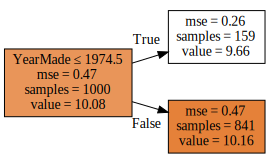

In [32]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

To find a split we are going to go through every possible value for which we can split on and split the data into the right hand side (rhs) and left hand side (lhs).  We want to know how much information is gained by splitting on this value.  TO do that we can calculate the Gini, cross-entropy, the rmse, ....   Instead of using the rmse, we are going to use the standard deviation of the two groups which is equivalent to the rmse for an unbiased estimator.  The reason why standard deviation works is that we are trying to split our data into as different groups as possible, and so within each group there should be less deviation.  For example, if we were splitting cats and dogs, if we could split them completely then the standard deviation for each group would be zero, while if they were completely mixed our standard deviation would be much higher.

Practically we do the following. 

- Iterate through each possible value in the feature 
- For each value, split the outcomes into two groups, those whose values are higher than the curent value and those equal to or lower than our current value
- For each group calculate the standard deviation
- Take the weighted mean of the standard deviation for the two groups, where the weight is determined by the relative number of observations in each group


In [34]:
def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    for i in range(1,self.n-1):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum()==0: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

note that the above code is not trying to be optimized, so instead of cehcking just the unique values of x we are going through every value of x, which most probably means there will be a lot of redundancy.

In [35]:
%timeit find_better_split(tree,1)
tree

230 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

In [36]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

We can see that splitting on `MachineHoursCurrentMeter` results in a score of 681 and splitting on `YearMade` gives a lower (and better) score of 658.  So we should split on `YearMade` and if we look at the RF, this is what it does as well and splits on the same value as our implementation and has the same value.

### Speeding things up

In [37]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

Let's convert our previous non-optimized code from $O\left(n^2\right)$ to $O\left(n\right)$.  One thing to note is that we can optimize the calcuation of the standard deviation by using the following relationship

$$
\begin{array}
\sqrt{\dfrac{1}{N}\sum\limits_{i=1}^N \left(x_i - \bar{x}\right)^2 } =& \sqrt{\dfrac{1}{N}\sum\limits_{i=1}^N \left(x_i^2 - \dfrac{2}{N}x_i\sum\limits_{i=1}^N x_i + \left(\dfrac{1}{N}\sum\limits_{i=1}^N x_i\right)^2 \right)} \\ 
= & \sqrt{\dfrac{1}{N}\sum\limits_{i=1}^N \left(x_i^2\right) - 2 \left(\dfrac{1}{N}\sum\limits_{i=1}^N x_i\right)^2 + \left(\dfrac{1}{N}\sum\limits_{i=1}^N x_i\right)^2 }\\
= &\sqrt{\left(\dfrac{1}{N}\sum\limits_{i=1}^N x_i^2\right) -\left(\dfrac{1}{N}\sum\limits_{i=1}^N x_i\right)^2  }
\end{array}
$$

In [59]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf-1):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [42]:
%timeit find_better_split_foo(tree,1)
tree

2.86 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251353; split:3744.0; var:MachineHoursCurrentMeter

In [43]:
find_better_split_foo(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In python we can dynamically add the method `find_better_split` by assigning it to the method in `DecisionTree`

In [60]:
DecisionTree.find_better_split = find_better_split

In [45]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

## Full single tree

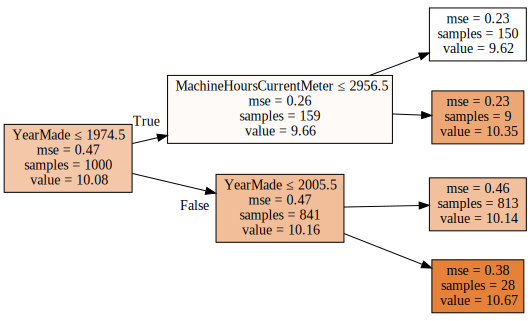

In [46]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [48]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [49]:
DecisionTree.find_varsplit = find_varsplit

In [50]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

In [51]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888348357; split:2800.0; var:MachineHoursCurrentMeter

In [52]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045129; split:2005.0; var:YearMade

In [53]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.08938082949389; split:2273.0; var:MachineHoursCurrentMeter

In [54]:
tree.lhs.rhs

n: 9; val:10.354428077535193; score:3.758445623594074; split:3113.0; var:MachineHoursCurrentMeter

## Predictions

In [56]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [62]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 616 ms, sys: 20.6 ms, total: 637 ms
Wall time: 635 ms


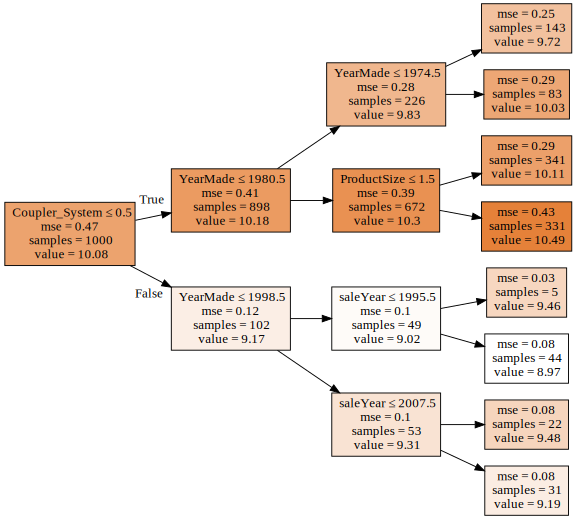

In [64]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=8)

In [65]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

In [66]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

```python
t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
```
is a ternary operator, not a control flow statement.  While they do the same thing, the ternary operator is more human readable

In [ ]:
if something:
    x= do1()
else:
    x= do2()

In [ ]:
x = do1() if something else do2()

In [ ]:
x = something ? do1() : do2()

In [67]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 147 ms, sys: 9.48 ms, total: 156 ms
Wall time: 362 ms


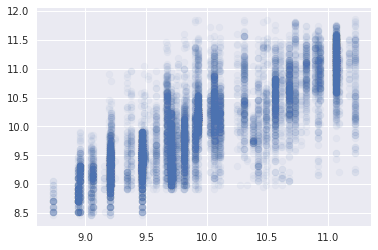

In [68]:
plt.scatter(preds, y_valid, alpha=0.05)

In [69]:
metrics.r2_score(preds, y_valid)

0.5037152213688234

CPU times: user 10.4 ms, sys: 1.26 ms, total: 11.6 ms
Wall time: 385 ms


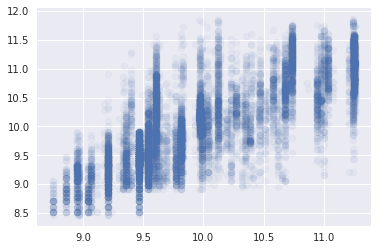

In [70]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

In [71]:
metrics.r2_score(preds, y_valid)

0.47541053100694763

# Putting it together

In [ ]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [ ]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [ ]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [ ]:
preds = ens.predict(X_valid[cols].values)

In [ ]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [ ]:
metrics.r2_score(y_valid, preds)

In [ ]:
%load_ext Cython

In [ ]:
def fib1(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib2(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = a + b

In [ ]:
%timeit fib1(50)

In [ ]:
%timeit fib2(50)

In [ ]:
%timeit fib3(50)